# Pruning Neural Networks at Init

---

This is a take at pruning Networks before training on MNIST data. The Notebook explains the used operations etc.

## Imports and Data-Preparation

In [151]:
## Settings
model_type = "LeNet5"  ## Choice of "LeNet5" and "Dense"

In [152]:
## Tensorflow related
import tensorflow as tf; tf.random.set_seed(42)
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Conv2D, Dense

## General
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from tqdm import tqdm

## Importing Pruned Model
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
import src.masked_keras as msk
import src.wrappers as wrp

In [153]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = wrp.load_mnist()
num_classes = 10
## Pad if necessairy
if model_type == "Dense":
    X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_test  = np.pad(X_test,  ((0,0),(2,2),(2,2),(0,0)), 'constant')

---

## Defining the Model and Loss

In [154]:
## Defining the Model with Sequential API
if model_type == "Dense":
    def get_model(w_init=None):
        model = keras.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(num_classes, activation="softmax")])
        if w_init: 
            model.set_weights(w_init)
        return model

if model_type == "LeNet5":
    def get_model(w_init=None):
        model = keras.Sequential([
            layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
                input_shape=X_train.shape[1:]),
            layers.AveragePooling2D(),
            layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
            layers.AveragePooling2D(),
            layers.Flatten(),
            layers.Dense(units=120, activation='relu'),
            layers.Dense(units=84, activation='relu'),
            layers.Dense(units=10, activation = 'softmax')])
        if w_init: 
            model.set_weights(w_init)
        return model

## Extract init-model weights for training after pruning
model = get_model()
w_init = model.get_weights()

## Shortcut for masked model
def get_masked_model(trainable_mask: bool, masks=None):
    model = get_model()
    model.set_weights(w_init)
    if masks is None:
        masks = [tf.ones_like(w) for w in model.trainable_weights]
    if trainable_mask:
        return msk.TrackableMaskedModel(masks, model)
    else:
        return msk.StaticMaskedModel(masks, model)

In [155]:
loss_fn = keras.losses.CategoricalCrossentropy()

In [156]:
print(f"Test-Accuracy at init: {wrp.model_accuracy(model, X_test, y_test):.2f}")

Test-Accuracy at init: 0.14


---

## GraSP Pruning

Pruning logic by from [Wang, et al. (2020)](https://openreview.net/pdf?id=SkgsACVKPH). They exploit the following property: Let $N, F\in \mathbb N$
$$
    \mathbf f:\mathbb R^F \to \mathbb R^N, \ \mathbf x \mapsto \mathbf f(\mathbf x)\, .
$$
Furthermore let $\mathbf v \in \mathbb R^F$, such that $\mathbf f(\mathbf x)^T\mathbf v \in \mathbb R$. Then
$$\begin{align*}
    \Big[ \nabla_{\mathbf x} \big(\mathbf f(\mathbf x)^T \mathbf v\big)\Big]_i &= \frac{\partial}{\partial x_i} \big(\mathbf f(\mathbf x)^T \mathbf v\big) = \frac{\partial}{\partial x_i} \sum_{j=1}^N f_j(\mathbf x) v_j \\
    &= \sum_{j=1}^N \frac{\partial f_j(\mathbf x)}{\partial x_i} v_j = \big[ D\mathbf f(\mathbf x)^T \,\mathbf v \big]_i \, .
\end{align*}$$
This can be used to calculate Jacobian-vector-producs using only gradients. Specifically for $\mathbf f$ being the gradient of some scalar function $\varphi(\mathbf x)$ this yields for the Hessian-vector-product (Hessians are symmetric under smoothness conditions):
$$
    H\varphi(\mathbf x) \, \mathbf v = \nabla \Big( \nabla \varphi^T \mathbf v \Big)\, .
$$
Using the gradient but already evaluated at some $\mathbf x_0$ (equiv to <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">tf</span><span style="color:white;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">.</span><span style="color:#dcdcaa;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">stop_gradient</span>) this yields the formula used in the paper (p. 5). This is then called the Hessian-gradient product, i. e. <span style="color:#9cdcfe;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">Hvp</span>.

Maybe also take a look at the minimal example in the [auxiliary notebook](./_aux.ipynb). Below I show how to also calulate the <span style="color:#9cdcfe;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">Hvp</span> using a <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">Forward</span><span style="color:white;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">.</span><span style="color:#dcdcaa;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">Accumulator</span> which explicitly implements jacobian-vector-products. 

In [157]:
## Reset Model
model = get_model()
model.set_weights(w_init)

## GraSp batch:
X_grasp, y_grasp = wrp.random_batch(X_train, y_train, batch_size=512)

In [158]:
## Pruning Scores:
with tf.GradientTape(persistent=True) as outer_tape:
    with tf.GradientTape() as inner_tape:
        y_pred = model(X_grasp)
        loss = loss_fn(y_grasp, y_pred)
    gradients = inner_tape.gradient(loss, model.trainable_variables)
    int_Hgp = tf.reduce_sum([tf.reduce_sum(g * tf.stop_gradient(g)) for g in gradients])
Hgps = outer_tape.gradient(int_Hgp, model.trainable_variables)

In [159]:
## Plain Hessian-gradient-product
with tf.autodiff.ForwardAccumulator(
    model.trainable_variables,
    gradients) as acc:
    with tf.GradientTape() as tape:
        y_pred = model(X_grasp)
        loss = loss_fn(y_grasp, y_pred)
    gradients_new = tape.gradient(loss, model.trainable_variables)
Hgps_acc = acc.jvp(gradients_new)

In [160]:
[np.allclose(Hgp1, Hgp2) for Hgp1, Hgp2 in zip(Hgps, Hgps_acc)]

[True, True, True, True, True, True, True, True, True, True]

In [161]:
## Calculating the scores:
grasp_scores = [w*Hgp for w, Hgp in zip(model.trainable_weights, Hgps)]

## Train a GraSP-pruned Model

In [162]:
grasp_masks = wrp.generate_pruning_mask(grasp_scores, sparsity=0.9)
grasp_model = get_masked_model(trainable_mask=False, masks=grasp_masks)
print(f"Accuracy at init: {wrp.model_accuracy(grasp_model, X_test, y_test):.2f}")

Accuracy at init: 0.11


In [163]:
grasp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

In [164]:
pruned_fit = grasp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128,
    verbose=1
)

469/469 [==============================] - 3s 5ms/step - loss: 1.0580 - accuracy: 0.6545 - val_loss: 0.4631 - val_accuracy: 0.8662


---

## ProsPr Pruning

Pruning logic from [Alizadeh et al. (2022)](https://arxiv.org/pdf/2202.08132.pdf). Custom training loop modified from [Géron (2019)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). 

### Plain-Meta Gradient

First I show that it is not possible (using a typical - depth APIs) to implement the meta-gradient as stated in the reference:
$$\begin{align}
    g = \frac{\partial}{\partial \mathbf c} \mathcal L(\mathbf{w}_M) = \frac{\partial \mathcal L(\mathbf{w}_M)}{\partial \mathbf{w}_M} \Bigg[ \prod_{m=1}^M \underbrace{\frac{\partial \mathbf{w}_m}{\partial \mathbf{w}_{m-1}}}_{\Gamma_m} \Bigg] \cdot \mathbf{w}_{\textsf{init}}
\end{align}$$
with <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">tensorflow</span>. To enable the autodiff engine to keep track of the masks ($c$'s), it is necessairy to override the forward passes of the model's layers such that the inputs are directly affected by the weights and they can be used as model-parameters. Yet this should only happen for the first batch (cf. Alizadeh et al., 2022, pp. 3-4).

In [165]:
## Checking if `first_call` reset works
mask_factor = 1
model = get_model(w_init)
full_masks = [tf.ones_like(w) for w in model.trainable_weights]
masked_model = msk.TrackableMaskedModel(full_masks, model)

X_batch, y_batch = wrp.non_random_batch(X_train, y_train, 0, 256)
w_names_old = [w.name for w in masked_model.trainable_weights]
test1 = masked_model.layers[0].layers[0](X_batch)
_ = masked_model(X_batch)
masked_model.unmask_forward_passes()
test2 = masked_model.layers[0].layers[0](X_batch)
print("All suitable?", np.all(test1 == mask_factor*test2))
print("Trainable vars kept?", 
    w_names_old == [w.name for w in masked_model.trainable_weights])

Masking <keras.layers.convolutional.Conv2D object at 0x000002156E219250>
Masking <keras.layers.convolutional.Conv2D object at 0x000002156E2476A0>
Masking <keras.layers.core.Dense object at 0x000002156E230FA0>
Masking <keras.layers.core.Dense object at 0x000002154562FB20>
Masking <keras.layers.core.Dense object at 0x000002155EFD0B80>
All suitable? True
Trainable vars kept? True


Still the problem with <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">tensorflow</span> in this scenario is, that it is not possible to track parameters through <span style="color:#dcdcaa;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">assign</span>-operations, i. e. through multiple batch-update steps. 

The following cells shows the minimal example using $w'(c) = w\cdot c$, $f = 2\cdot w'$. This should yield:
$$\begin{align*}
    f \Big\vert_{w=4,\ c=2} &= 2\cdot w\cdot c \Big\vert_{w=4,\ c=2} = 16 \, , \\
    \frac{\partial}{\partial c} f \Big\vert_{w=4,\ c=2} &= 2w \Big\vert_{w=4} = 8
\end{align*}$$

In [166]:
w = tf.Variable([4.])
c = tf.Variable([2.])

with tf.GradientTape() as tape:
    tape.watch(c)
    w.assign(w * c)
    f = 2. * w

print(f"f = {f.numpy()[0]:.0f}")
print(f"df/dc = {tape.gradient(f, c)}")

f = 16
df/dc = None


This yields the following problem (I have opened a [stackoverflow question](https://stackoverflow.com/q/75185053/19838867) regaring this): The gradients w. r. t. the masks are `None`. The problem also occurs with a <span style="color:#9cdcfe;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">test_factor</span>, that I multiply to the first loss for test purposes:

In [167]:
masked_model = get_masked_model(True)
optimizer = keras.optimizers.SGD(learning_rate=0.05)

Masking <keras.layers.convolutional.Conv2D object at 0x000002156E3FDC70>
Masking <keras.layers.convolutional.Conv2D object at 0x000002156E219820>
Masking <keras.layers.core.Dense object at 0x000002156E247370>
Masking <keras.layers.core.Dense object at 0x000002156E2478E0>
Masking <keras.layers.core.Dense object at 0x000002156F9170D0>


In [168]:
test_factor = tf.Variable(1., dtype=tf.float32)
with tf.GradientTape(persistent=True) as outer_tape:
    outer_tape.watch(masked_model.masks)
    outer_tape.watch(test_factor)

    ## First btach
    X_batch, y_batch = wrp.non_random_batch(X_train, y_train, 0, 256)
    with tf.GradientTape() as tape1:
        y_pred = masked_model(X_batch)
        loss = test_factor*loss_fn(y_batch, y_pred)
    gradients = tape1.gradient(loss, masked_model.proper_weights)

    ## Updating weights
    for w, g in zip(masked_model.proper_weights, gradients):
        # w = w - 0.05*g # This version yields to no updates being performed on the weights
        w.assign(w - 0.05 * g)

    ## Unmasking
    masked_model.unmask_forward_passes()

    ## Second batch (and more)
    X_batch, y_batch = wrp.non_random_batch(X_train, y_train, 1, 256)
    with tf.GradientTape() as tape2:
        y_pred = masked_model(X_batch)
        loss = loss_fn(y_batch, y_pred)
    gradients = tape2.gradient(loss, masked_model.proper_weights)

print(outer_tape.gradient(loss, masked_model.masks))
print(outer_tape.gradient(loss, test_factor))

ListWrapper([None, None, None, None, None, None, None, None, None, None])
None


Checking if updates have been applied to the weights:

In [169]:
[np.allclose(w1, w2) for w1, w2 in zip(masked_model.proper_weights, w_init)]

[False, False, False, False, False, False, False, False, False, False]

This would be the full loop if the gradient would work through <span style="color:#dcdcaa;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">assign</span>-operations:

In [170]:
if False:
    n_max = 10
    with tf.GradientTape() as outer_tape:
        outer_tape.watch(masked_model.masks)

        ## First weight & iteration: w0 = c * w_init
        X_batch, y_batch = wrp.non_random_batch(X_train, y_train, 0, 256)
        with tf.GradientTape() as inner_tape:
            y_pred = masked_model(X_batch)
            loss = loss_fn(y_batch, y_pred)
        gradients = inner_tape.gradient(loss, masked_model.proper_weights)
        optimizer.apply_gradients(zip(gradients, masked_model.proper_weights)) 
        
        ## Unmasking for rest of iterations
        masked_model.unmask_forward_passes()

        ## Remaining prune-loop steps
        for n in range(1, n_max):
            X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, 256)

            with tf.GradientTape() as inner_tape:
                y_pred = masked_model(X_batch)
                loss = loss_fn(y_batch, y_pred)
            gradients = inner_tape.gradient(loss, masked_model.proper_weights)
            optimizer.apply_gradients(zip(gradients, masked_model.proper_weights)) 

            print(f"Step: {n+1} -- Loss: {loss.numpy():.3f}", end="\r")
        
    meta_gradients = outer_tape.gradient(loss, masked_model.masks)
    # scores_meta_g = wrp.compute_prospr_scores_from_meta_g(meta_gradients)
    # masks_meta_g = wrp.generate_pruning_mask(scores_meta_g, 0.9)

### "Straming" Meta-Gradients

[Alizadeh et al. (2022)](https://arxiv.org/pdf/2202.08132.pdf) use the following update in the "prune loop":
$$
    \mathbf{w}_{m+1} = \mathbf w_m - \alpha \frac{\partial \mathcal L(\mathbf{w}_m, \mathcal D_m)}{\partial \mathbf{w}_m} \, .
$$
The ProsPr scores are then calculates using eq. (1) which is eq. (10) in their paper on page 4. Using the abbreviation
$$
    \Gamma_m = \mathbf{1} - \alpha \underbrace{\frac{\partial^2 \mathcal L(\mathbf{w}_{m-1}, \mathcal D_{m-1})}{\partial \mathbf{w}_{m-1}^2}}_{\textsf{Hessian}\ \ H\mathcal L} \, .
$$
eq. (1) can be rewritten to
$$
    g = \frac{\partial}{\partial \mathbf c} \mathcal L(\mathbf{w}_M) = \frac{\partial \mathcal L(\mathbf{w}_M)}{\partial \mathbf{w}_M} \Bigg[ \prod_{m=1}^M \Gamma_m\Bigg] \cdot \mathbf{w}_{\textsf{init}} \, .
$$
Till now, this is consistent with the notation from the paper, with the "gradients" notes as partial derivatives. **But note, that in the paper the notation is abused**. Each derivative is simply noted as a gradient, yet there is actually more dimensionality going on. 

#### Proper Chain Rule Application
Assume $\mathbf w_m \in \mathbb R^F$, $F\in \mathbb N, \ m=1,...,M$ and $\mathcal L: \mathbb R^F \to \mathbb R$. The exact shapes can be tracked by the used package. The mask $c$ would therefore be of shape $\mathbb R^F$ as well. This would yield: 
$$
    g = \frac{\partial}{\partial \mathbf c} \mathcal L \in \mathbb R^F = \nabla_{\mathbf c} \mathcal L \, .
$$
The chain rule through the update $\mathbf w$'s would therefore consist of multiple Jacobians:
$$
    g = (\nabla_{\mathbf w_M} \mathcal L)^T \Bigg[ \prod_{m=1}^M (D_{\mathbf w_{m-1}} w_m) \Bigg] (D_{\mathbf c}\mathbf w_0)\, .
$$
Specifically note the last object $D_{\mathbf c} \mathbf w_0$ which is acutally not simply $\mathbf w_{\textsf{init}}$ as noted in the paper but 
$$
    D_{\mathbf c} \mathbf w_0 = \mathrm{diag}(w_{01}, ..., w_{0F}) \, .
$$
The problem is, that these jacobians are two large to track even with easy architechtures as the ones used in this notebook. Trying to run the next cell yields to `OverflowError: Python int too large to convert to C long` (<span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">tf</span>-version: 2.6.0):

In [171]:
if False:
    model = get_model(w_init)
    masks = [tf.Variable(tf.ones_like(w),
        name=w.name[:-2]+"/mask")
        for w in model.trainable_weights]
    weights = [tf.Variable(w.numpy()) for w in model.trainable_weights]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(masks)
        w0 = [c*w for c, w in zip(masks, weights)]
    grad = []
    for w0i in w0:
        grad.append(tape.jacobian(w0i, masks))

The problem is, that this "direction" of gradient can not make use of the trackable Jacobian-vetor-products that are already mentiones in the GraSp-Pruning section.

### Approximative ProsPr Scores

Despite the above mentioned problems when trying to implement ProsPr-pruning in <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">tensorflow</span> the approximation method [(Alizadeh et al., 2022, p. 5)](https://arxiv.org/pdf/2202.08132.pdf), because this can be framed as a Jacobian-vector-product. Assume the same shapes and notations as above. Then in first-order approximation it is:
$$
    \nabla_{\mathbf c} \mathcal L = (\nabla_{\mathbf w_M} \mathcal L)^T \cdot D_{\mathbf c}\mathbf w_{0} =  D_{\mathbf c}\mathbf w_{0} \cdot \nabla_{\mathbf w_M} \mathcal L \, .
$$
This holds because $D_{\mathbf c}\mathbf w_{0}$ is a diagonal matrix and therefore symmetric. $\nabla_{\mathbf w_M} \mathcal L =: \mathbf v \in \mathbb R^F$ can be tracked by <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">tensorflow</span>'s autodiff. With the same argument as in the GraSP-pruning section this yields:
$$
    \nabla_{\mathbf c} \mathcal L = \nabla_{\mathbf c} \big( \mathbf w_0^T \mathbf v \big)
$$

In [172]:
masked_model = get_masked_model(trainable_mask=False)
optimizer = keras.optimizers.SGD(0.05)
for n in range(10):
    X_batch, y_batch = wrp.random_batch(X_train, y_train, 256)

    with tf.GradientTape() as inner_tape:
        y_pred = masked_model(X_batch)
        loss = loss_fn(y_batch, y_pred)
    gradients = inner_tape.gradient(loss, masked_model.proper_weights)
    optimizer.apply_gradients(zip(gradients, masked_model.proper_weights)) 
    print(f"Step: {n+1} -- Loss: {loss.numpy():.3f}", end="\r")

In [173]:
masks =   [tf.Variable(c) for c in masked_model.get_masks()]
weights = [tf.Variable(w) for w in w_init]

with tf.GradientTape(persistent=True) as tape:
    tape.watch(masks)
    w0s = [c*w for c, w in zip(masks, weights)]
    integral = tf.reduce_sum(
        [tf.reduce_sum(w0 * tf.stop_gradient(g))
        for w0, g in zip(w0s, gradients)])
meta_gradients = tape.gradient(integral, masks)
prospr_scores  = wrp.compute_prospr_scores_from_meta_g(meta_gradients)


## Train ProsPr-pruned Model

In [174]:
prospr_masks = wrp.generate_pruning_mask(prospr_scores, 0.9)
prospr_model = get_masked_model(trainable_mask=False, masks=prospr_masks)

print(f"Accuracy at init: {wrp.model_accuracy(prospr_model, X_test, y_test):.2f}")

prospr_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

Accuracy at init: 0.20


In [175]:
pruned_fit = prospr_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128
)

469/469 [==============================] - 3s 6ms/step - loss: 0.9797 - accuracy: 0.6961 - val_loss: 0.4347 - val_accuracy: 0.8717


In [176]:
## Confirm that the mask has not been trained
[np.all(mm == m) for mm, m in zip(prospr_model.masks, prospr_masks)]

[True, True, True, True, True, True, True, True, True, True]

## Sparsity vs. Accuracy

In [177]:
sparsity_range = np.linspace(0.9, 1., 40)

In [178]:
## ProsPr Pruning
accuracy_prospr = []
loss_prospr = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        prospr_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    prospr_model = get_masked_model(False, masks)

    prospr_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = prospr_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_prospr.append(pruned_fit.history['val_accuracy'])
    loss_prospr.append(pruned_fit.history['val_loss'])

100%|██████████| 40/40 [01:55<00:00,  2.88s/it]


In [179]:
## GraSP Pruning
accuracy_grasp = []
loss_grasp = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        grasp_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    grasp_model = get_masked_model(False, masks)

    grasp_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = grasp_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_grasp.append(pruned_fit.history['val_accuracy'])
    loss_grasp.append(pruned_fit.history['val_loss'])

100%|██████████| 40/40 [01:53<00:00,  2.83s/it]


In [183]:
## Random Pruning
model = get_model(w_init)
weight_shapes = [var.shape for var in model.trainable_weights]
accuracy_random = []
loss_random = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_random_pruning_mask(
        weight_shapes, 
        sparsity=sparsity)
    random_model = get_masked_model(False, masks)

    random_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = random_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_random.append(pruned_fit.history['val_accuracy'])
    loss_random.append(pruned_fit.history['val_loss'])

100%|██████████| 40/40 [01:54<00:00,  2.85s/it]


In [184]:
labels_acc  = ["rand. pruning acc.", "ProsPr acc.", "GraSp acc."]
labels_loss = ["rand. pruning loss", "ProsPr loss", "GraSp loss"]
data_acc  = [accuracy_random, accuracy_prospr, accuracy_grasp]
data_loss = [    loss_random,     loss_prospr,     loss_grasp]
lines_acc  = ["k-",  "r-",  "g-"]
lines_loss = ["k--", "r--", "g--"]

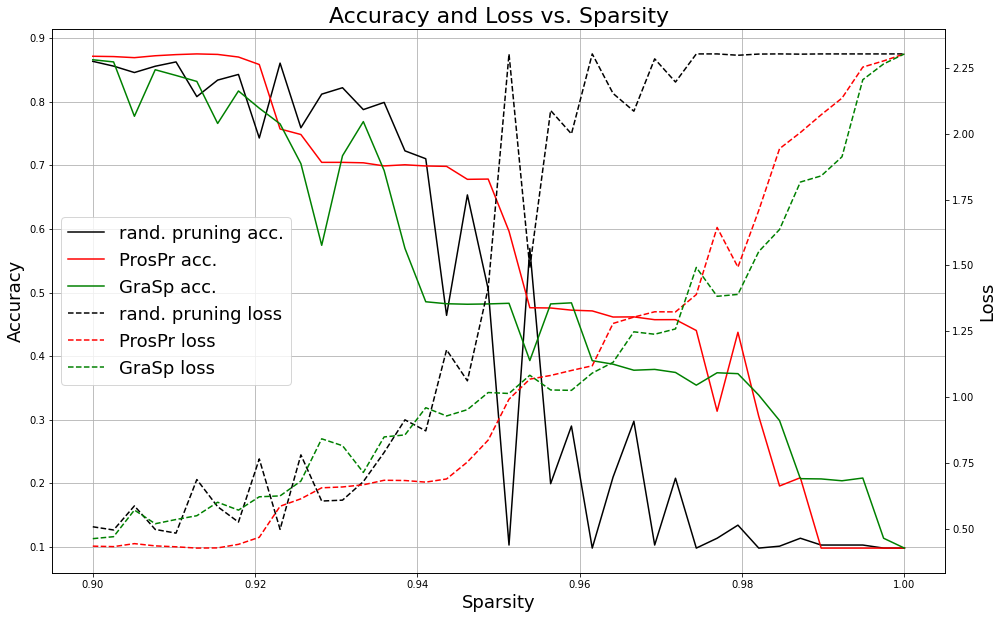

In [185]:
fig, ax0 = plt.subplots(figsize=(16, 10))
ax1 = ax0.twinx()
ax0.set_title("Accuracy and Loss vs. Sparsity", fontsize=22)

plt_acc  = [ax0.plot(sparsity_range, data, line, label=label) 
    for data, line, label in zip(data_acc, lines_acc, labels_acc)]
plt_loss = [ax1.plot(sparsity_range, data, line, label=label) 
    for data, line, label in zip(data_loss, lines_loss, labels_loss)]

ax1.set_ylabel("Loss", fontsize=18)
ax0.set_xlabel("Sparsity", fontsize=18)
ax0.set_ylabel("Accuracy", fontsize=18)
ax0.grid()
lns = [l[0] for l in plt_acc + plt_loss]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', fontsize=18)
plt.show()
plt.close()